# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Python: Cross-validation for regularization
#### Instructor: sincxpress.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

In [2]:
# import the data

matfile = sio.loadmat('MATLAB_data_files//CEdata.mat')
EEG = matfile['EEG'][0,0]
EEG['times'] = EEG['times'][0]
EEG['data'] = np.double(EEG['data'])

In [3]:
## get covariance matrices

# filter data in alpha
centerFreq = 7
freqFWHM = 4

fdata = copy.deepcopy(EEG['data'])
for ti in range(int(EEG['trials'])):
    tmdat = EEG['data'][:,:,ti]
    fdata[:,:,ti] = filterFGx(tmdat,EEG['srate'][0][0],centerFreq,freqFWHM)[0]


# time window
tidx1 = np.argmin(np.abs(EEG['times']))
tidx2 = np.argmin(np.abs(EEG['times']-800))
    
# covariance matrices
covR = np.zeros( (EEG['nbchan'][0][0],EEG['nbchan'][0][0]) )
covS = np.zeros( (EEG['nbchan'][0][0],EEG['nbchan'][0][0]) )

for ti in range(EEG['trials'][0][0]):
    
    # this trial's covariance
    thisTrialCov = np.cov(fdata[:,tidx1:tidx2,ti])
    
    # if correct trial
    if ti<125:
        covR += thisTrialCov
    else:
        covS += thisTrialCov
    
# average covariances by dividing by trials
covR = covR/125
covS = covS/125

In [4]:
## cross-validation

# range of gamma parameter values
gammas = np.linspace(0,.5,43)

# initialize matrices
maxLambdas = np.zeros(len(gammas))
comptsRMS  = np.zeros(len(gammas))
Renergy    = np.zeros(len(gammas))


# loop over gamma values
for gi in range(len(gammas)):
    
    # regularize
    g = gammas[gi]
    R = (1-g)*covR + g*np.mean(np.linalg.eig(covR)[0])*np.eye(EEG['nbchan'][0][0])
    
    # GED and sorting index
    evals,evecs = scipy.linalg.eigh(covS,R)
    sidx = np.argsort(evals)[::-1]
    
    # component time series
    Cdata = fdata[:,:,:125]
    Edata = fdata[:,:,125:]
    comp_tsC = evecs[:,sidx[0]].T @ np.reshape(Cdata[:,tidx1:tidx2,:],(64,-1),order='F')
    comp_tsE = evecs[:,sidx[0]].T @ np.reshape(Edata[:,tidx1:tidx2,:],(64,-1),order='F')
    
    # store max eigenvalue and component energy
    maxLambdas[gi] = np.max(np.abs(evals))
    comptsRMS[gi]  = np.sqrt(np.mean(comp_tsE**2)) / np.sqrt(np.mean(comp_tsC**2))
    Renergy[gi]    = np.linalg.norm(R)

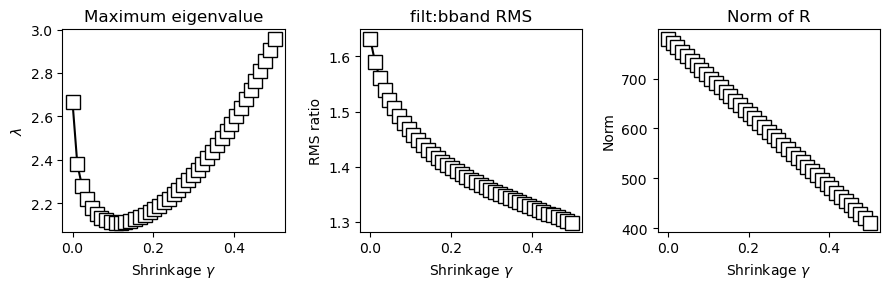

In [5]:
## plot the xval results

_,axs = plt.subplots(1,3,figsize=(9,3))

axs[0].plot(gammas,maxLambdas,'ks-',markerfacecolor='w',markersize=10)
axs[0].set_xlabel('Shrinkage $\gamma$')
axs[0].set_ylabel('$\lambda$')
axs[0].set_title('Maximum eigenvalue')

axs[1].plot(gammas,comptsRMS,'ks-',markerfacecolor='w',markersize=10)
axs[1].set_xlabel('Shrinkage $\gamma$')
axs[1].set_ylabel('RMS ratio')
axs[1].set_title('filt:bband RMS')

axs[2].plot(gammas,Renergy,'ks-',markerfacecolor='w',markersize=10)
axs[2].set_xlabel('Shrinkage $\gamma$')
axs[2].set_ylabel('Norm')
axs[2].set_title('Norm of R')


plt.tight_layout()
plt.show()

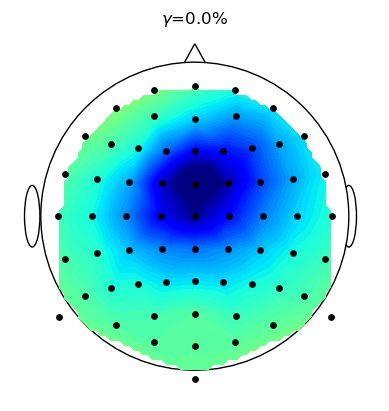

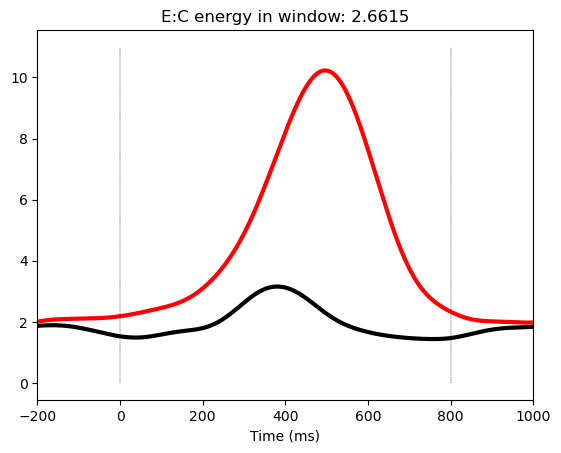

In [9]:
## apply the "best" regularization parameter

# get the best parameter
bestGammaLoc = np.argmax(comptsRMS)

regu_gam = #gammas[bestGammaLoc]


# apply the regularization
Rregu = (1-regu_gam)*covR + regu_gam*np.mean(np.linalg.eig(covR)[0])*np.eye(EEG['nbchan'][0][0])



### GED etc
evals,evecs = scipy.linalg.eigh(covS,Rregu)
# sort according to eigenvalues
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]

# component time series
comp_ts = evecs[:,0].T @ np.reshape(fdata,(64,-1),order='F')

# power time series
comp_powts = np.abs(scipy.signal.hilbert(comp_ts))**2
comp_powts = np.reshape( comp_powts,(EEG['pnts'][0][0],EEG['trials'][0][0]),order='F' )


# topoplot of component map
topoplotIndie(evecs[:,0].T@covS,EEG['chanlocs'],f'$\gamma$={100*regu_gam:.1f}%')
plt.show()

# power time series
plt.plot(EEG['times'],np.mean(comp_powts[:,:125],axis=1),'k',linewidth=3)
plt.plot(EEG['times'],np.mean(comp_powts[:,125:],axis=1),'r',linewidth=3)
plt.plot([0,0],[0,11],'k--',linewidth=.3)
plt.plot([800,800],[0,11],'k--',linewidth=.3)
plt.xlim([-200, 1000])
plt.xlabel('Time (ms)')

powC = comp_powts[:,:125]
powE = comp_powts[:,125:]
relpow = np.mean(np.mean(powE[tidx1:tidx2])) / np.mean(np.mean(powC[tidx1:tidx2]))
plt.title(f'E:C energy in window: {relpow:.4f}')

plt.show()